# problem statement 
https://hrcdn.net/s3_pub/istreet-assets/FF6SlkZoM_bAM33iJHQqNQ/Data%20Challenge%20Problem%20Statement.pdf

A successful submission for this challenge includes documented code (in your preferred coding language) along with plots, images and data to support your conclusions.



We are using the links to directly access the given data and storing it in variables `stockData` and `indexData`

In [ ]:
# stock prices
stockPath = "https://hrcdn.net/s3_pub/istreet-assets/LCKLs25NDFKItkntyXJmIg/data_challenge_stock_prices.csv"

# index prices
indexPath = "https://hrcdn.net/s3_pub/istreet-assets/zr4e83QS7wuUE_0aAFOEVg/data_challenge_index_prices.csv"

# online version
from urllib.request import urlopen
stockData = list(map(lambda x: x.decode(),urlopen(stockPath).readlines()))
indexData = list(map(lambda x: x.decode(),urlopen(indexPath).readlines()))

In [ ]:
# stock prices
stockPath = "./data_challenge_stock_prices.csv"

# index prices
indexPath = "./data_challenge_index_prices.csv"

# offline version
# stockData = list(map(lambda x: x.strip(),open(stockPath,'r').readlines()))
# indexData = list(map(lambda x: x.strip(),open(indexPath,'r').readlines()))

calculating the returns for each stock and storing it in a variable `ret`

In [ ]:
import numpy as np

# convert data
stockIds, stockData1 = list(map(float,stockData[0].split(','))), stockData[1:]
stockData1 = np.array(list(map(lambda x: list(map(float,x.split(','))),stockData1)))
indexIds, indexData1 = list(map(float,indexData[0].split(','))), indexData[1:]
indexData1 = np.array(list(map(lambda x: list(map(float,x.split(','))),indexData1)))

# calculate returns
N, M = stockData1.shape
_, I = indexData1.shape
ret = 1e4 * (np.concatenate((stockData1,stockData1[-1].reshape(1,-1))) - np.concatenate((stockData1[0].reshape(1,-1),stockData1))) / np.concatenate((stockData1[0].reshape(1,-1),stockData1))
ret = ret[1:-1]

Using the information provided in https://www.datanovia.com/en/lessons/determining-the-optimal-number-of-clusters-3-must-know-methods/

We calculate the Kmeans for different number of clusters, plot the Sum Squared Error(SSE) and then choose a appropriate value of `n_clusters` such that the error change is minimal after the chosen number of clusters, this is done as less number of clusters are desirable for better generalization but enough clusters should be chosen such that all the different types of stocks are classified

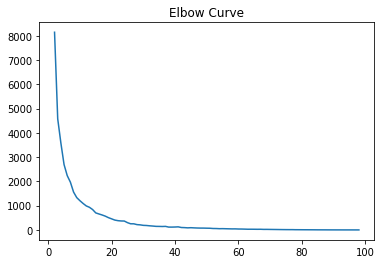

In [ ]:
# get cluster count (Elbow method)
# https://www.datanovia.com/en/lessons/determining-the-optimal-number-of-clusters-3-must-know-methods/

from math import sqrt
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

ret_df = pd.DataFrame(ret)
mean = ret_df.mean() * 252
var = ret_df.std() * sqrt(252)

mean.column = ["mean"]
var.column = ["Variance"]

data = pd.concat([mean, var], axis = 1)

X =  data.values 
sse = []
for k in range(2,99):
    kmeans = KMeans(n_init = 'auto', n_clusters = k)
    kmeans.fit(X)
    sse.append(kmeans.inertia_) 

plt.plot(range(2,99), sse)
plt.title("Elbow Curve")
plt.show()

A variable `cluster_count` can be populated with the required number of clusters

In [ ]:
cluster_count = 10
clusters = {}
ret_clusters = {}

In this we Calculate the K-Means cluster and then plot all the stocks 

In [ ]:
!pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Reference https://www.kaggle.com/code/izzettunc/introduction-to-time-series-clustering/notebook 

PCA with 10 components and then KMeans is used instead of a `Time Series K Mean` as takes  a large amount of time for the whole data, and to provide a better generizability, as is mentioned in the blog above

The function automatically plots the graphs in the best possible configuration

As can be seen in the plots the clusters are very well differentiated with all the stocks in a cluster having the same general shape, The stocks are also pretty evenly distributed between the clusters

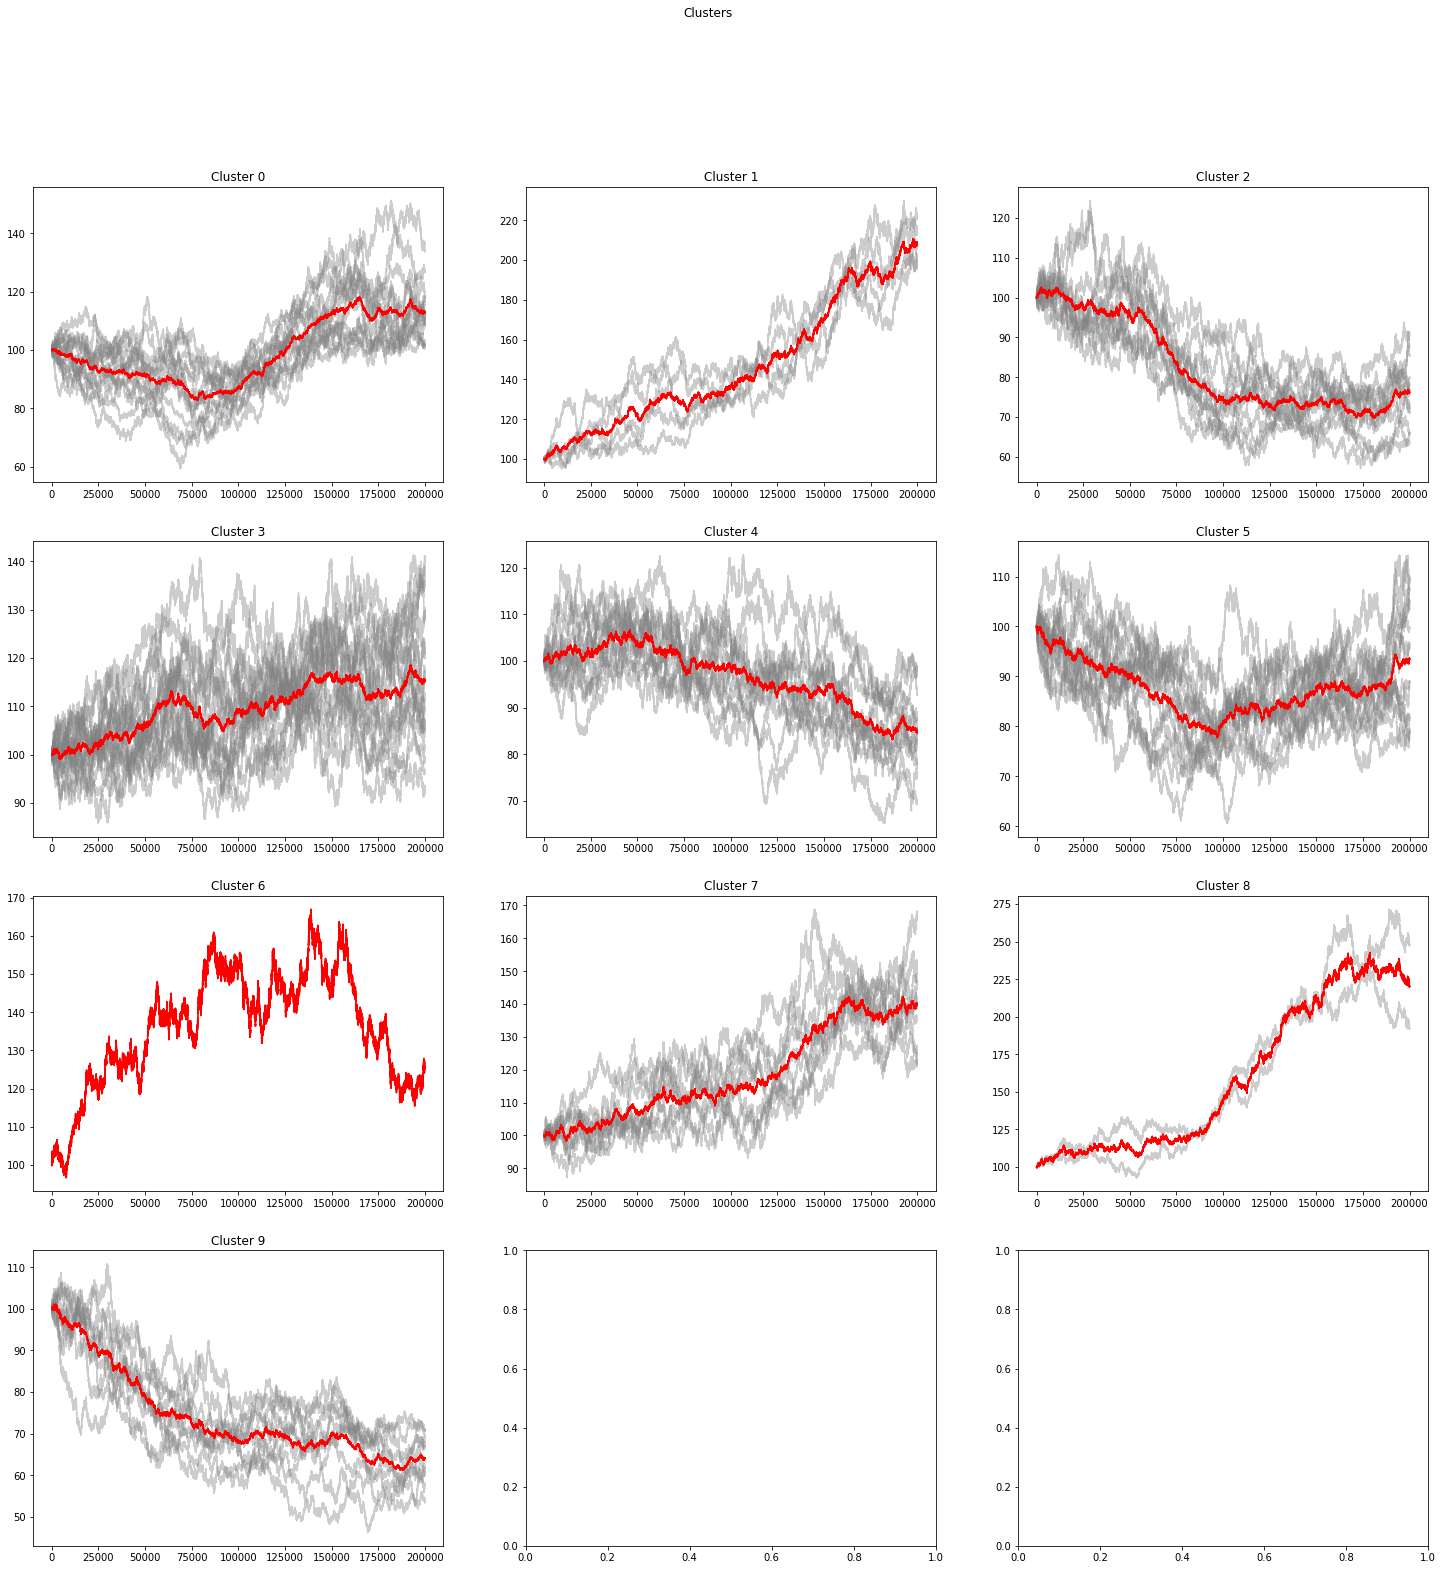

In [ ]:
# get the clusters
import pylab as pl
import math
# from tslearn.clustering import TimeSeriesKMeans
from sklearn.decomposition import PCA

def show_clusters(labels, cluster_count):
    global clusters
    plot_count = math.ceil(math.sqrt(cluster_count))
    column_count = math.ceil(cluster_count / plot_count)
    fig, axs = plt.subplots(plot_count, column_count,figsize=(25,25))
    fig.suptitle('Clusters')
    row_i=0
    column_j=0
    for label in range(0,cluster_count):
        cluster = []
        cluster1 = []
        for i in range(100):
            if(labels[i]==label):
                axs[row_i, column_j].plot(stockData1[:,i],c="gray",alpha=0.4)
                cluster.append(stockData1[:,i])
                cluster1.append(ret[:,i])
        clusters[label] = cluster
        ret_clusters[label] = cluster1
        if len(cluster) > 0:
            axs[row_i, column_j].plot(np.average(cluster,axis=0),c="red")
        axs[row_i, column_j].set_title("Cluster "+str(label))
        column_j+=1
        if column_j%column_count == 0:
            row_i+=1
            column_j=0
    plt.show()

pca = PCA(n_components = 10)
pca_data = pca.fit_transform(stockData1.T)
# km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")

kmeans = KMeans(n_init = 10, n_clusters = cluster_count).fit(pca_data)
labels = kmeans.labels_

df = pd.concat([pd.DataFrame(stockIds), pd.DataFrame(labels)], axis = 1)
df.columns = ["Index", "label"]

show_clusters(df["label"], cluster_count)

Plotting all the indices as a reference and to verify that the indices and some cluster have a comparable shape and can be correlated

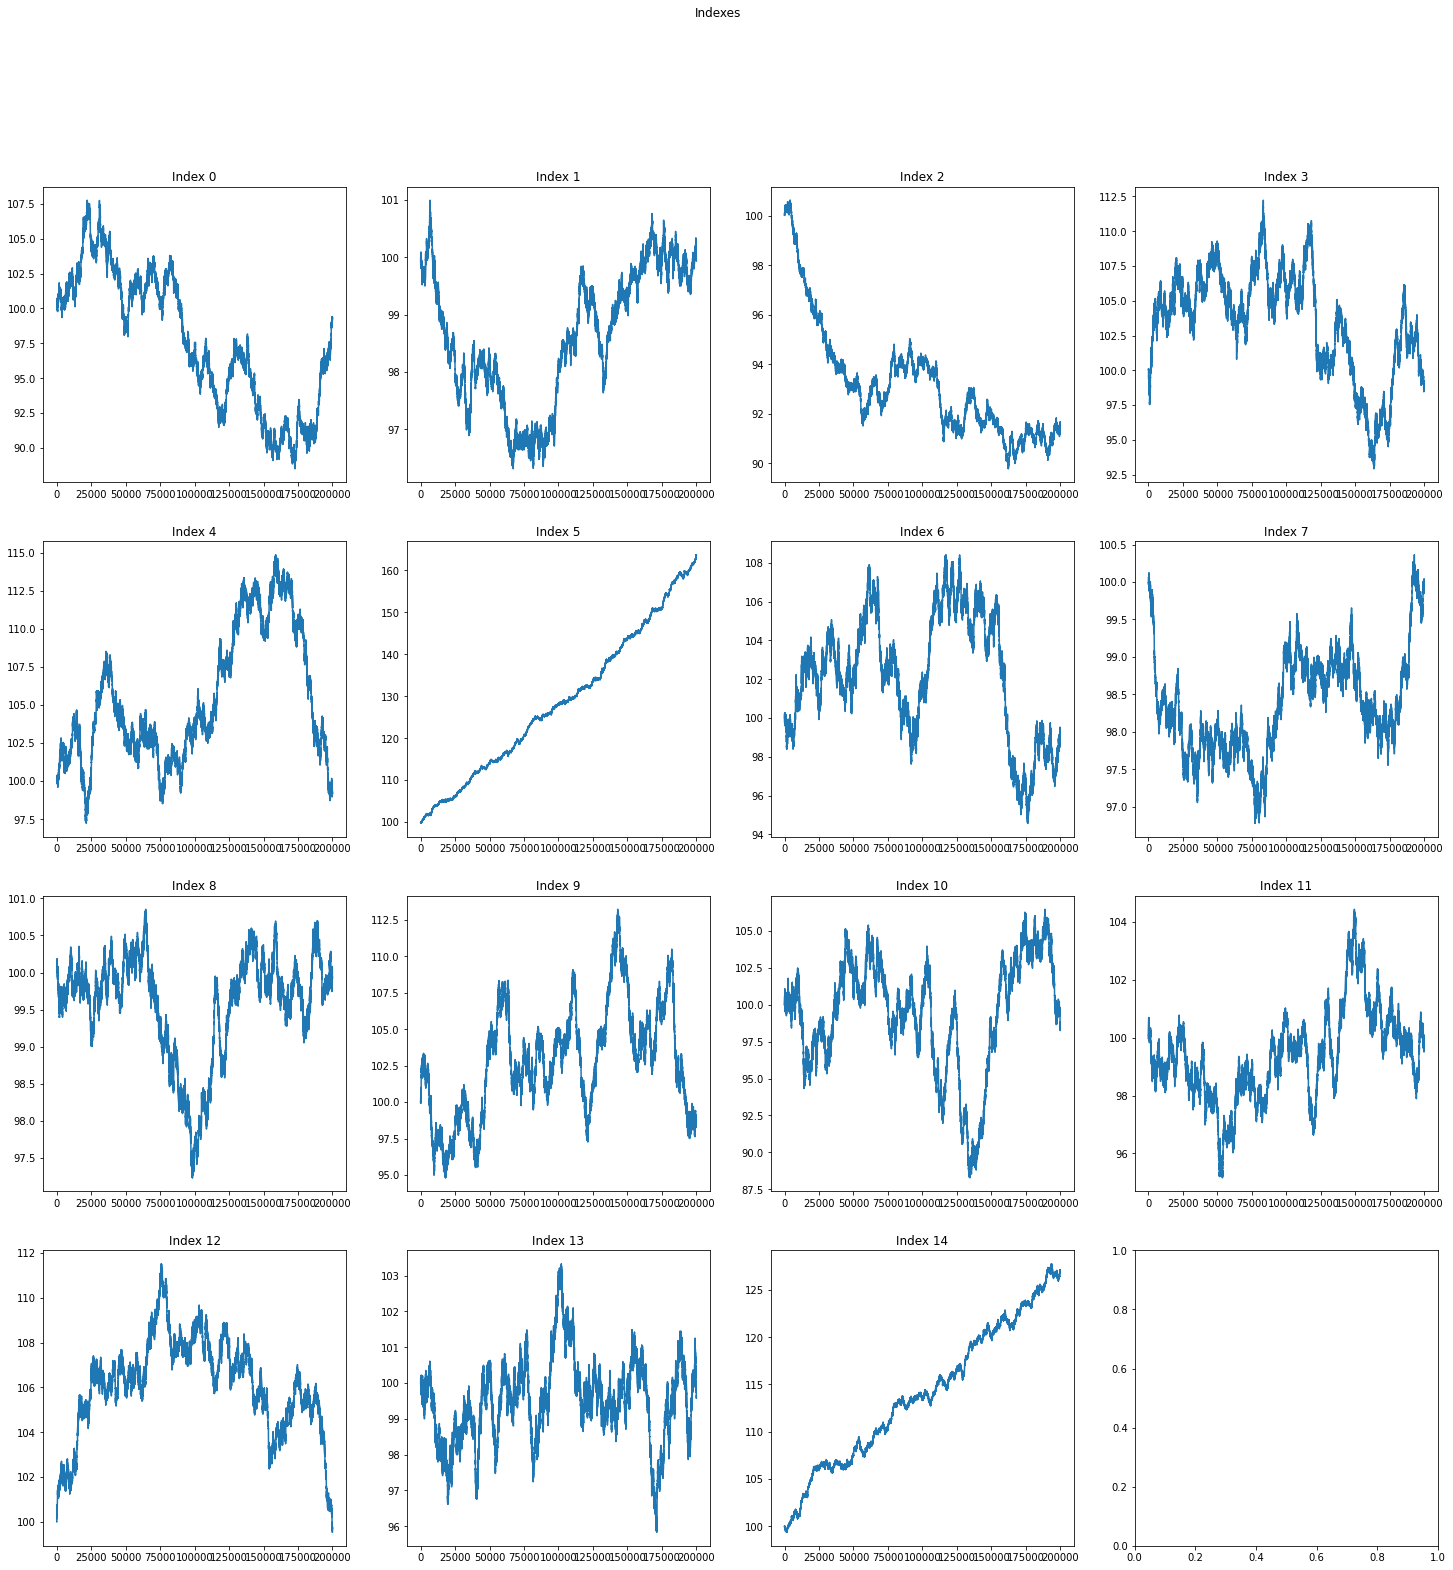

In [ ]:
plot_count = 4
column_count = 4
fig, axs = plt.subplots(plot_count, column_count,figsize=(25,25))
fig.suptitle('Indexes')
row_i=0
column_j=0
for i in range(15):
    axs[row_i, column_j].plot(indexData1[:,i])
    axs[row_i, column_j].set_title("Index "+str(i))
    column_j+=1
    if column_j%column_count == 0:
        row_i+=1
        column_j=0
plt.show()

This code fits a Linear Regression model for all the sectors of stocks with each given index and then chooses the best sector corresponding to each block 

The metric used to compare is accuracy

It also plots the each index with its best fitted prediction

[3, 3, 3, 0, 3, 7, 3, 0, 3, 3, 3, 0, 3, 5, 9]
[array([100.83330305, 100.82286792, 100.81634577, ...,  96.91482503,
        96.9073241 ,  96.930482  ]), array([99.15115029, 99.14726617, 99.15227993, ..., 99.80790573,
       99.80561352, 99.79633033]), array([97.88803783, 97.88937667, 97.90640715, ..., 92.11050532,
       92.12615395, 92.10969254]), array([105.1978223 , 105.21201528, 105.20266012, ..., 101.33014973,
       101.33409927, 101.35325178]), array([101.9685567 , 101.97249916, 101.93752808, ...,  99.23755581,
        99.24883157,  99.30696781]), array([108.70860503, 108.73342851, 108.7429015 , ..., 162.42225774,
       162.34515317, 162.33380357]), array([99.0681625 , 99.09557764, 99.08640381, ..., 97.79013657,
       97.77348192, 97.81414868]), array([99.28785283, 99.29279446, 99.29593256, ..., 99.91913298,
       99.91734639, 99.91711624]), array([ 99.22069154,  99.22445005,  99.22056472, ..., 100.50195919,
       100.50485493, 100.49815883]), array([ 99.33774681,  99.3245711

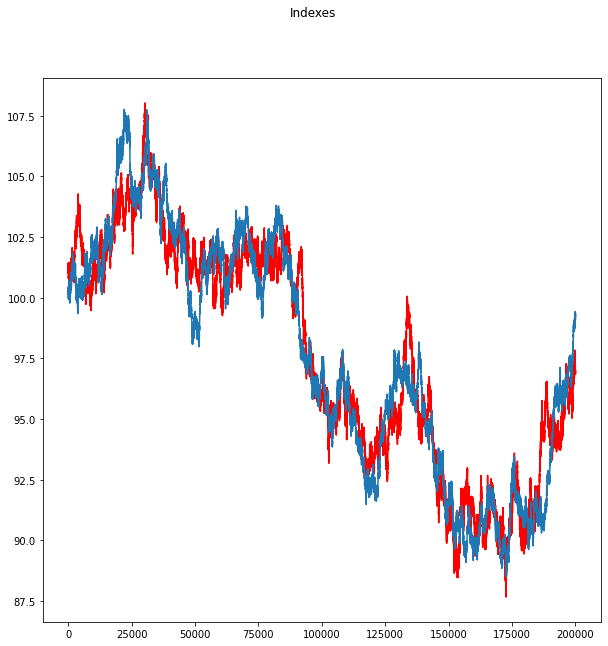

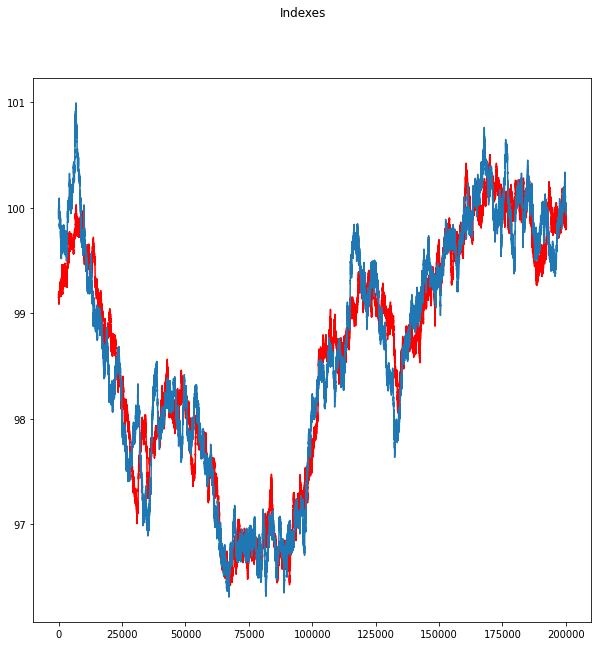

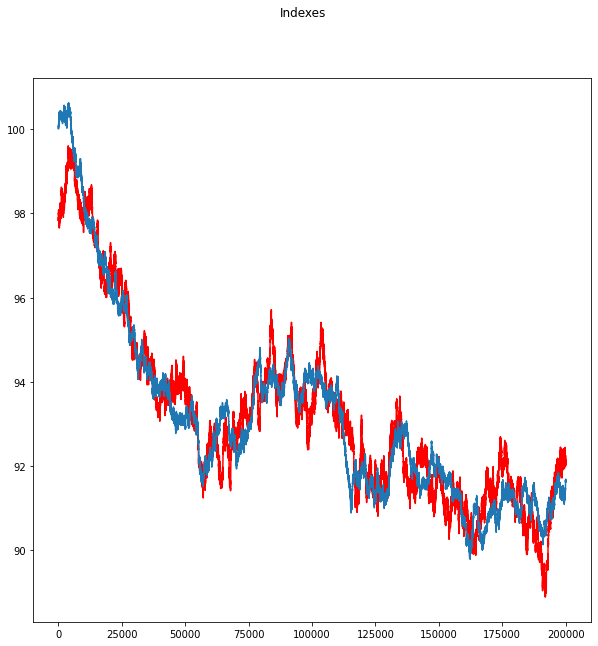

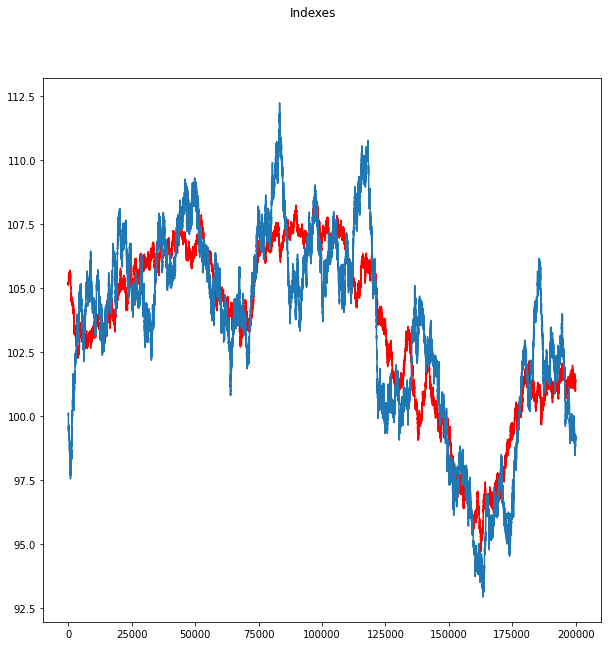

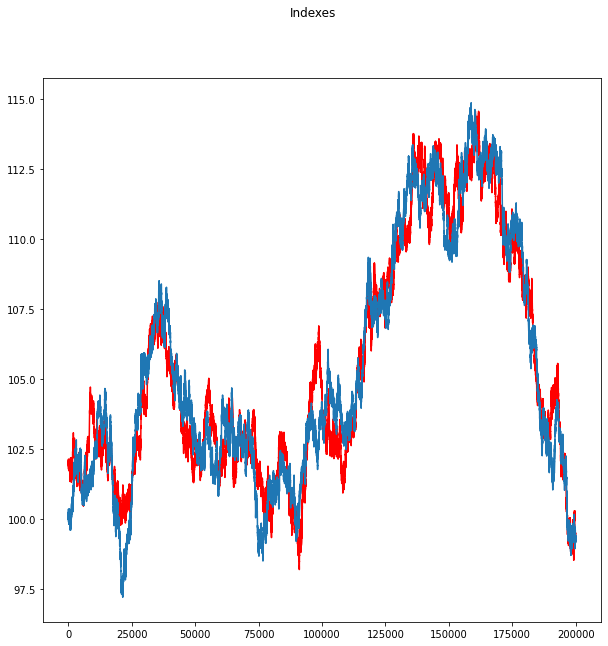

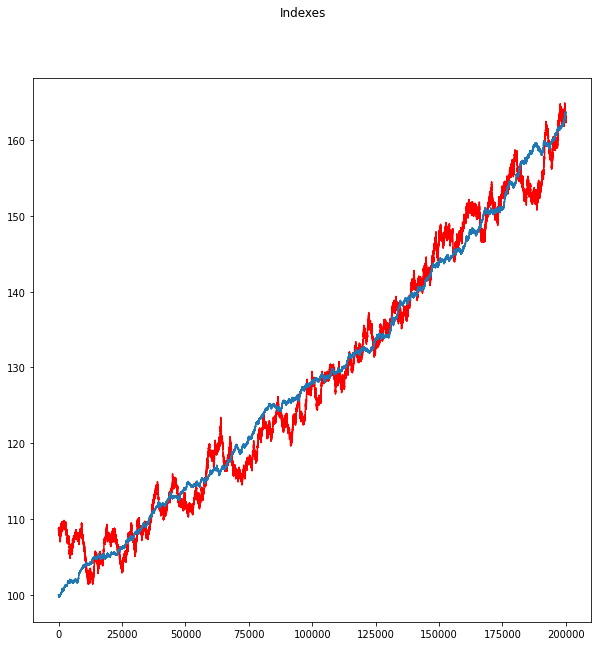

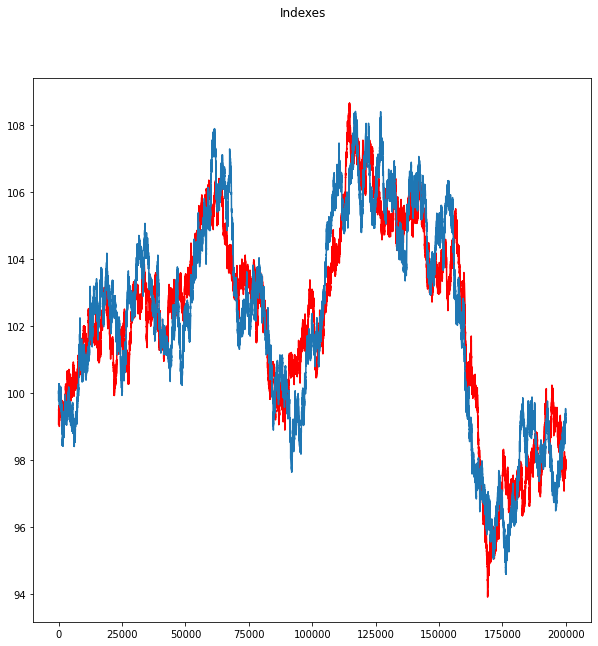

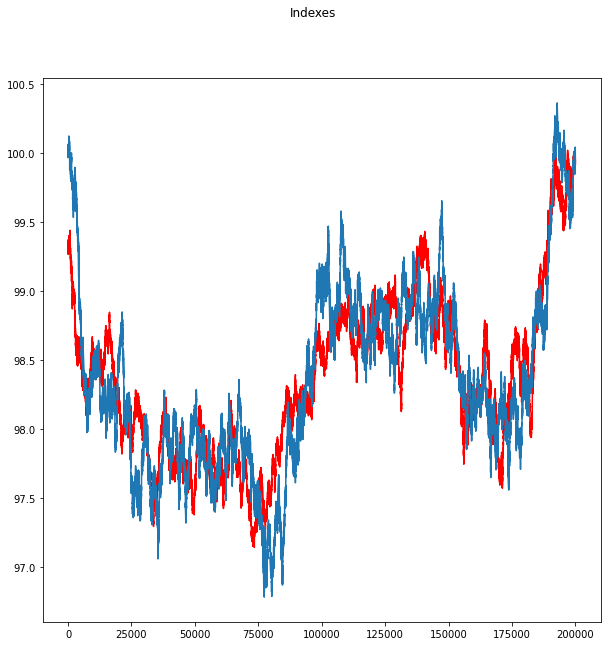

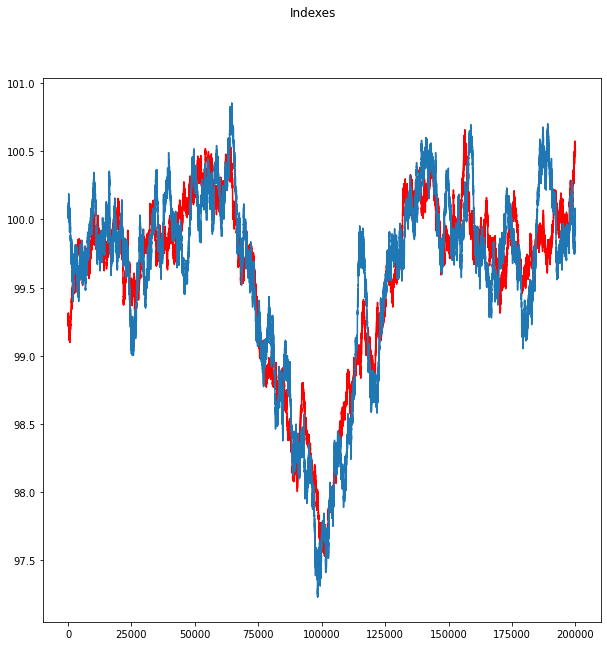

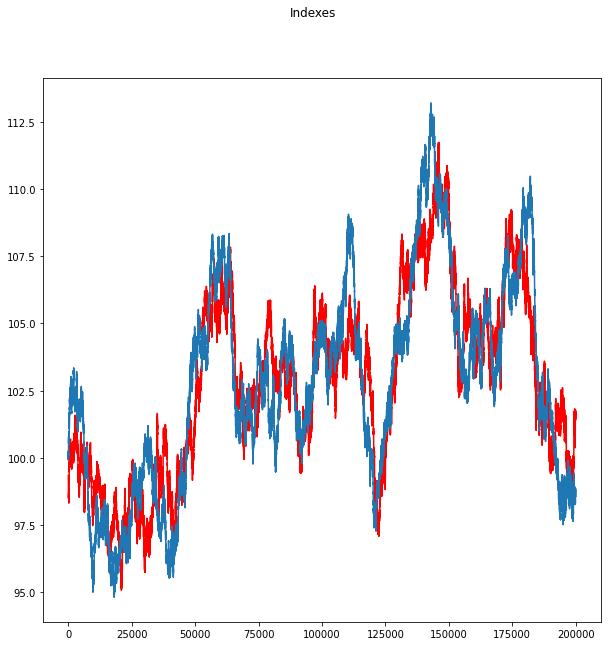

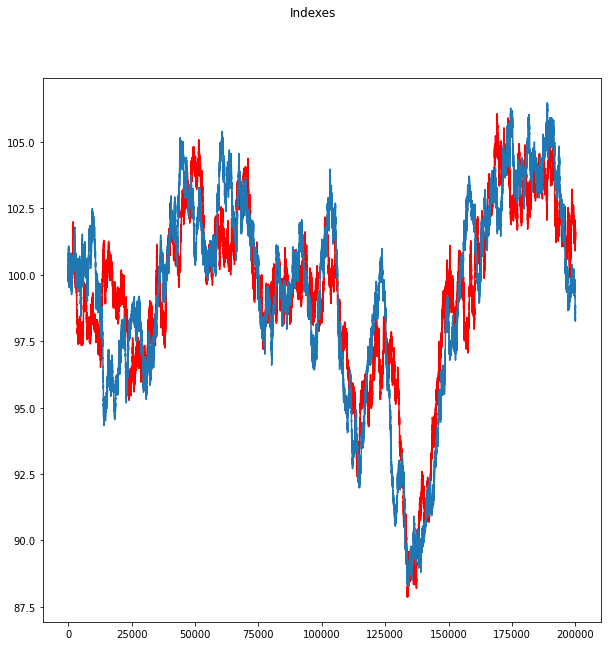

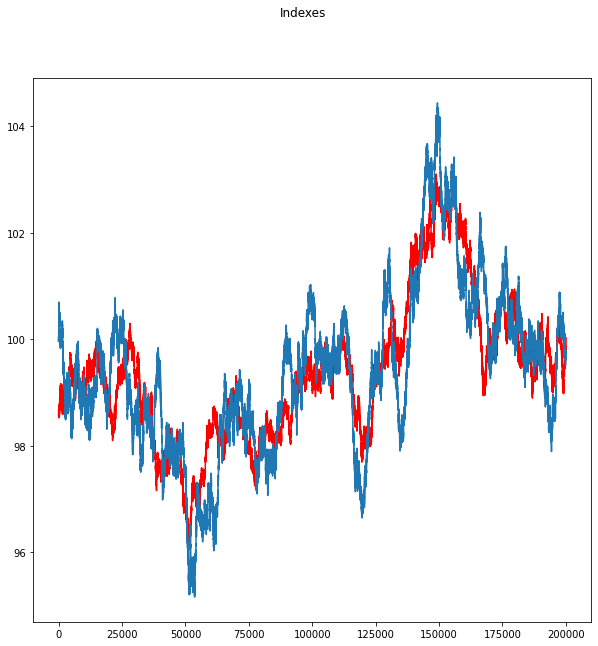

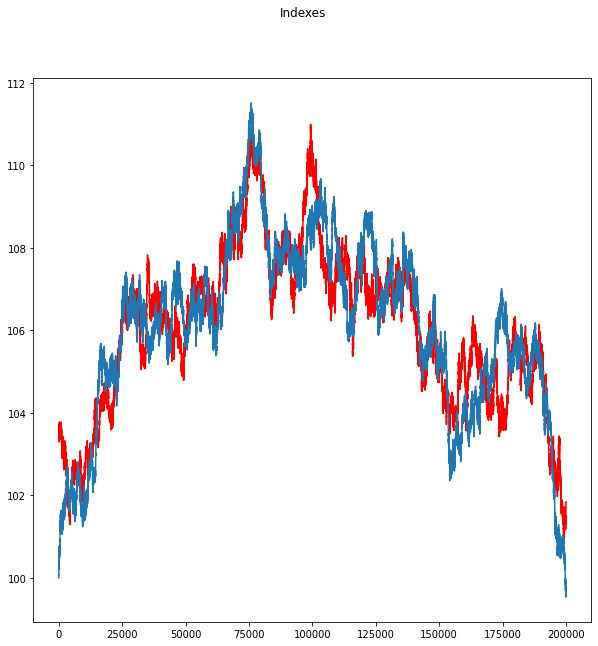

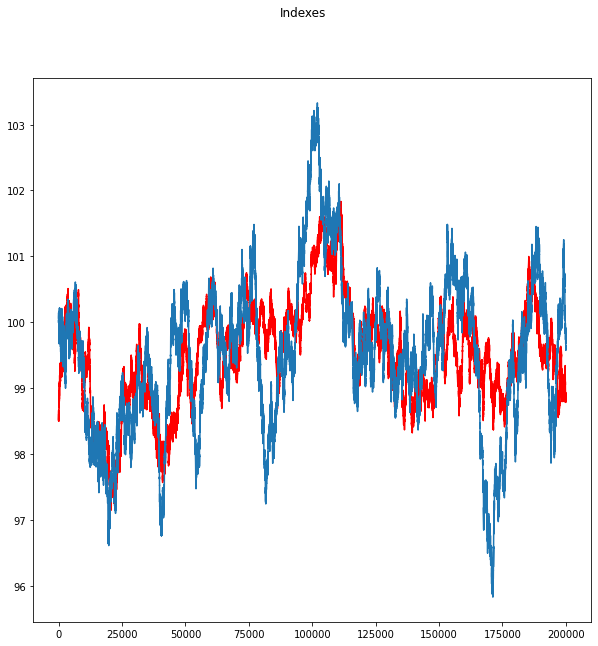

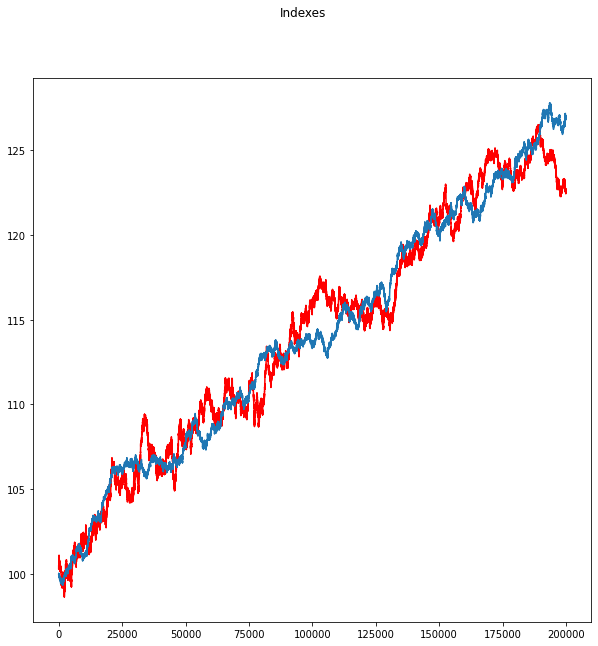

In [ ]:
# fit-predict
import torch
from sklearn.linear_model import SGDRegressor, LinearRegression

index_ret = 1e4 * (np.concatenate((indexData1,indexData1[-1].reshape(1,-1))) - np.concatenate((indexData1[0].reshape(1,-1),indexData1))) / np.concatenate((indexData1[0].reshape(1,-1),indexData1))
index_ret = index_ret[1:-1]
index_sectors = []
preds = []
for idx in np.array(indexData1).T:
    acc = []
    curr_preds = []
    for sec, rets in clusters.items():
        # model = SGDRegressor(penalty = 'l2', max_iter = 1000)
        model = LinearRegression()
        model.fit(torch.from_numpy(np.array(rets)).to(dtype=torch.float32).T,torch.from_numpy(idx))
        pred = model.predict(torch.from_numpy(np.array(rets)).T)
        curr_preds.append(pred)
       
        # print(model.score(torch.from_numpy(np.array(rets)).to(dtype=torch.float32).T, idx))
        acc.append(np.sum(abs(pred - idx) < 1) / N)
    index_sectors.append(acc.index(max(acc)))
    preds.append(curr_preds[acc.index(max(acc))])

print(index_sectors)
print(preds)

for i in range(15):
    fig, axs = plt.subplots(1, 1,figsize=(10,10))
    fig.suptitle('Indexes')
    axs.plot(preds[i], color = 'red')
    axs.plot(indexData1[:, i])
    plt.show()


In [ ]:
# computing covariance
preds = np.array(preds).T
pred_cov = np.cov(preds.T)
print(preds.shape)
print(pred_cov.shape)

(15, 200000)
(15, 15)


Assumptions: it is possible to trade the index at time t - 1 and then correspondingly the stocks in its sector at time t.

In [ ]:
# trading strategy
pred_returns = 1e4 * (np.concatenate((preds,preds[-1].reshape(1,-1))) - np.concatenate((preds[0].reshape(1,-1),preds))) / np.concatenate((preds[0].reshape(1,-1),preds))
print(pred_returns.shape)

allocation = []
for t in range(N):
    alloc = np.zeros((I))
    for i in range(I):
        if pred_returns[t][i] > np.sum(ret_clusters[index_sectors[i]]):
            alloc[i] += 1 / I
            alloc -= 1 / (I * I)
        else:
            alloc[i] -= 1 / I
            alloc += 1 / (I * I)
    allocation.append(alloc)

tot_ret = 0
for t in range(N):
    for i in range(I):
        tot_ret += allocation[t][i] * (pred_returns[t][i] - np.sum(ret_clusters[index_sectors[i]]))
print(tot_ret)